In [2]:
import pandas as pd
import numpy as np
import yaml
from importlib import resources as impresources
from recurrent_health_events_prediction import configs

from recurrent_health_events_prediction.model.NextEventPredictionModel import NextEventPredictionModel
from recurrent_health_events_prediction.training.utils import summarize_search_results
from recurrent_health_events_prediction.training.utils_survival import train_next_event_survival_model_rand_search_cv, save_coef_lifelines_plot
from recurrent_health_events_prediction.model.model_types import SurvivalModelType

## Import Configs and Load Preprocessed Data

In [3]:
with open((impresources.files(configs) / 'model_config.yaml')) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [4]:
training_data_config = data_config["training_data"]["mimic"]
next_event_model_config = model_config["mimic"]["next_event_model"]

In [5]:
next_event_model_config

{'last_event_based': {'model_name': 'survival_model',
  'model_type': None,
  'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based',
  'strata_col': None,
  'event_col': 'READMISSION_EVENT',
  'event_id_col': 'HADM_ID',
  'duration_col': 'EVENT_DURATION',
  'cluster_col': 'SUBJECT_ID',
  'features': ['NUM_PREV_HOSPITALIZATIONS',
   'LOG_DAYS_IN_ICU',
   'CHARLSON_INDEX']},
 'hmm_based': {'model_name': 'cph_model_hmm_cov_based',
  'model_type': 'cox_ph',
  'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival_based',
  'strata_col': None,
  'event_col': 'READMISSION_EVENT',
  'event_id_col': 'HADM_ID',
  'duration_col': 'EVENT_DURATION',
  'cluster_col': 'SUBJECT_ID',
  'features': ['NUM_PREV_HOSPITALIZATIONS',
   'LOG_DAYS_IN_ICU',
   'CHARLSON_INDEX']},
 'all_events_based': {'pwp_gap_time': {'model_name': 'recurrent_event_model',
   'model_type': 'cox_ph',
   'mode

In [6]:
training_data_path = training_data_config["preprocessed_path"]
print("Loading training data from:", training_data_path)
# last_events_df = pd.read_csv(training_data_path + "/last_events.csv")
# all_events_df = pd.read_csv(training_data_path + "/all_events.csv")
last_events_df = pd.read_csv("/workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/last_events.csv")
all_events_df = pd.read_csv("/workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/all_events.csv")

Loading training data from: /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure


## Filter Dataset

In [50]:
EXCLUDE_ELECTIVE = True
SELECT_ONLY_ONE_EVENT_PER_PATIENT = True
SELECT_PATIENTS_WITH_MORE_TOTAL_HOSP = False
MIN_HOSP_FREQ = 2  # minimum number of hospitalizations for a patient to be selected
SELECT_DISEASE = False
SET_OBSERVATION_WINDOW_SURVIVAL = True  # set observation window for survival analysis
OBSERVATION_WINDOW = 120  # days
SELECT_ONLY_PATIENTS_WITH_KNOWN_RETURN = False  # if True, patients who never returned after the last event are disconsidered
CONSIDER_ONLY_READMISSIONS_WITHIN_PERIOD = False
skip_filtering = False

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import set_observation_window

if not skip_filtering:
    if EXCLUDE_ELECTIVE:
        last_events_df = last_events_df[last_events_df["NEXT_ADMISSION_TYPE"] != "ELECTIVE"]
        all_events_df = all_events_df[all_events_df["NEXT_ADMISSION_TYPE"] != "ELECTIVE"]

    if SELECT_ONLY_ONE_EVENT_PER_PATIENT:
        # Select only the first event for each subject
        # This is done to avoid multiple events for the same subject in the training data
        # which can lead to overfitting and biased predictions.
        last_events_df = last_events_df.sort_values(['SUBJECT_ID', 'ADMITTIME']).groupby('SUBJECT_ID', as_index=False).first()

    if SELECT_PATIENTS_WITH_MORE_TOTAL_HOSP:
        last_events_df = last_events_df[last_events_df["TOTAL_HOSPITALIZATIONS"] >= MIN_HOSP_FREQ]
        all_events_df = all_events_df[all_events_df["TOTAL_HOSPITALIZATIONS"] >= MIN_HOSP_FREQ]
    
    if SET_OBSERVATION_WINDOW_SURVIVAL:
        last_events_df = last_events_df.apply(set_observation_window, args=(OBSERVATION_WINDOW,), axis=1)
        all_events_df = all_events_df.apply(set_observation_window, args=(OBSERVATION_WINDOW,), axis=1)

    if SELECT_ONLY_PATIENTS_WITH_KNOWN_RETURN:
        last_events_df = last_events_df[~last_events_df["DAYS_UNTIL_NEXT_HOSPITALIZATION"].isna()]
        all_events_df = all_events_df[~all_events_df["DAYS_UNTIL_NEXT_HOSPITALIZATION"].isna()]

    if SELECT_DISEASE:
        disease_mask = (last_events_df['HAS_COPD'] | last_events_df['HAS_CONGESTIVE_HF'])
        print("Num of prev rows last events dataframe: ", len(last_events_df))
        last_events_df = last_events_df[disease_mask]
        print("Num of rows last events dataframe after filtering: ", len(last_events_df))

        disease_mask = (all_events_df['HAS_COPD'] | all_events_df['HAS_CONGESTIVE_HF'])
        print("Num of prev rows all events dataframe: ", len(all_events_df))
        all_events_df = all_events_df[disease_mask]
        print("Num of rows all events dataframe after filtering: ", len(all_events_df))

    if CONSIDER_ONLY_READMISSIONS_WITHIN_PERIOD:
        # small sample of readmissions that are after the observation period
        # some survival models require at least one censored event
        last_readmissions_after_period_df = last_events_df[last_events_df['EVENT_DURATION'] >= OBSERVATION_WINDOW].sample(10)
        last_readmissions_after_period_df['READMISSION_EVENT'] = 0
        all_events_readmissions_after_period_df = all_events_df[all_events_df['EVENT_DURATION'] >= OBSERVATION_WINDOW].sample(10)
        all_events_readmissions_after_period_df['READMISSION_EVENT'] = 0

        # Filter out readmissions that are not within the observation period
        last_events_df = last_events_df[last_events_df['EVENT_DURATION'] < OBSERVATION_WINDOW]
        all_events_df = all_events_df[all_events_df['EVENT_DURATION'] < OBSERVATION_WINDOW]

        # Append the readmissions that are after the observation period
        last_events_df = pd.concat([last_events_df, last_readmissions_after_period_df], ignore_index=True)
        all_events_df = pd.concat([all_events_df, all_events_readmissions_after_period_df], ignore_index=True)

### Events Distribution

In [52]:
last_events_df["NEXT_ADMISSION_TYPE"].value_counts()

NEXT_ADMISSION_TYPE
EMERGENCY    1450
URGENT         17
Name: count, dtype: int64

In [53]:
all_events_df["NEXT_ADMISSION_TYPE"].value_counts()

NEXT_ADMISSION_TYPE
EMERGENCY    4953
URGENT         62
Name: count, dtype: int64

In [ ]:
import plotly.express as px

event_type_censoring_color_map = {
    "Event Ocurred": px.colors.qualitative.Plotly[0],
    "Censored": px.colors.qualitative.Plotly[4]
}

# Plot the distribution of EVENT_DURATION
fig = px.histogram(last_events_df, x='EVENT_DURATION', nbins=50, marginal='violin', opacity=0.7, color='READMISSION_EVENT',
                   labels={'EVENT_DURATION': 'Duration (days)', 'READMISSION_EVENT': 'Readmission Event'}, category_orders={'READMISSION_EVENT': [0, 1]})
fig.update_layout(title="Distribution of Event Duration - Last Events", yaxis_title="Count")
fig.show()

print(px.colors.qualitative.Plotly[2])

#00CC96


In [11]:
import plotly.express as px

# Plot the distribution of Previos Number of Hospitalizations
fig = px.histogram(last_events_df, x='NUM_PREV_HOSPITALIZATIONS', nbins=50, marginal='violin', opacity=0.7, color='READMISSION_EVENT',
                   labels={'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'READMISSION_EVENT': 'Readmission Event'})
fig.update_layout(title="Distribution of Number of Previous Hospitalizations - Last Events", yaxis_title="Count")
fig.show()

In [12]:
import plotly.express as px
total_hospitalizations = last_events_df.groupby('SUBJECT_ID')['TOTAL_HOSPITALIZATIONS'].first().reset_index()
# Plot the distribution of Previos Number of Hospitalizations
fig = px.histogram(total_hospitalizations, x='TOTAL_HOSPITALIZATIONS', marginal='violin',
                   labels={'TOTAL_HOSPITALIZATIONS': 'Total Number of Hospitalizations'})
fig.update_layout(title="Distribution of Total Number of Hospitalizations - Last Events", yaxis_title="Count")
fig.show()

In [13]:
import plotly.express as px

# Map values for better readability
readmission_mapping = {0: "No readmission within 120 days (censoring)", 1: "Readmission within 120 days"}
last_events_df['READMISSION_EVENT_MAPPED'] = last_events_df['READMISSION_EVENT'].map(readmission_mapping)

# Create the pie chart
px.pie(last_events_df, names='READMISSION_EVENT_MAPPED', title='Readmission Event and Censoring Fractions - Last Events',
       labels={'READMISSION_EVENT_MAPPED': 'Readmission Event'},
       color_discrete_sequence=['blue', 'red'], width=900).show()

In [14]:
last_events_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
       'ETHNICITY', 'INSURANCE', 'HOSPITALIZATION_DAYS', 'NUM_COMORBIDITIES',
       'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD', 'HAS_CONGESTIVE_HF',
       'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS', 'PREV_DISCHTIME',
       'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READMISSION_TIME_CAT',
       'READMISSION_TIME_CAT_ENCODED', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN', 'DAYS_UNTIL_NEXT_HOSP_PAST_STD',
       'TOTAL_HOSPITALIZATIONS', 'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES',
       'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'AGE', 'CHARLSON_INDEX',
       'FIRST_ADMITTIME', 'LAST_DISCHTIME', 'PARTICIPATION_DAYS',
       'TOTAL_PARTICIPATION_DAYS', 'READMISSION_EVENT', 'EVENT_DURATION',
       'IN

In [15]:
import plotly.express as px

# Map values for better readability
readmission_mapping = {0: "No readmission within 30 days", 1: "Readmission within 30 days"}
last_events_df['READMISSION_EVENT_MAPPED'] = last_events_df['READMISSION_30_DAYS'].map(readmission_mapping)

# Create the pie chart
px.pie(last_events_df, names='READMISSION_EVENT_MAPPED', title='Readmission Event 30 Days - Last Events',
       labels={'READMISSION_EVENT_MAPPED': 'Readmission Event'},
       color_discrete_sequence=['blue', 'red'], width=900).show()

last_events_df.drop(columns=['READMISSION_EVENT_MAPPED'], inplace=True)

In [16]:
print("Final number of unique subjects: ", last_events_df.SUBJECT_ID.nunique())
print("Final number of events: ", len(last_events_df))

Final number of unique subjects:  1690
Final number of events:  1690


## Survival Models

Traditional survival models. Only the last events are used for training (except for Cox PH with SE). Time to next event is the target variable.

In [7]:
evaluation_times = [15, 30, 60, 90, 100]

In [8]:
last_events_df['EVENT_DURATION'].describe()

count    2663.000000
mean      105.589710
std        33.610992
min         2.136111
25%       120.000000
50%       120.000000
75%       120.000000
max       120.000000
Name: EVENT_DURATION, dtype: float64

### Train-Test Split

In [9]:
last_events_df["RANDOM_FEATURE"] = np.random.rand(len(last_events_df))
all_events_df["RANDOM_FEATURE"] = np.random.rand(len(all_events_df))

In [10]:
from sklearn.discriminant_analysis import StandardScaler
from recurrent_health_events_prediction.training.utils_survival import train_test_split_survival_data

X_train, X_test = train_test_split_survival_data(last_events_df, duration_col="EVENT_DURATION", event_col="READMISSION_EVENT", q_bins=1)

features_to_scale = ["NUM_PREV_HOSPITALIZATIONS", "LOG_NUM_PREV_HOSPITALIZATIONS", "LOG_HOSPITALIZATION_DAYS",
                     "LOG_DAYS_IN_ICU", "AGE", "CHARLSON_INDEX", "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
                     'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM',
                     "NUM_COMORBIDITIES", "NUM_PROCEDURES", "NUM_DRUGS", "RANDOM_FEATURE"]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

Train set event composition:
 READMISSION_EVENT
0    0.812676
1    0.187324
Name: count, dtype: float64
Test set event composition:
 READMISSION_EVENT
0    0.851782
1    0.148218
Name: count, dtype: float64
Train average event duration: 104.94035732916014
Test average event duration: 108.18468574108817


In [11]:
X_train_all_events, X_test_all_events = train_test_split_survival_data(all_events_df, duration_col="EVENT_DURATION", event_col="READMISSION_EVENT", q_bins=1)

X_train_scaled_all_events = X_train_all_events.copy()
X_test_scaled_all_events = X_test_all_events.copy()

scaler = StandardScaler()

X_train_scaled_all_events[features_to_scale] = scaler.fit_transform(X_train_all_events[features_to_scale])
X_test_scaled_all_events[features_to_scale] = scaler.transform(X_test_all_events[features_to_scale])

Train set event composition:
 READMISSION_EVENT
0    0.647558
1    0.352442
Name: count, dtype: float64
Test set event composition:
 READMISSION_EVENT
0    0.638145
1    0.361855
Name: count, dtype: float64
Train average event duration: 91.49945242891104
Test average event duration: 91.02179902387692


### Feature Selection

In [12]:
from lifelines import CoxPHFitter
features = ["LOG_NUM_PREV_HOSPITALIZATIONS", "LOG_HOSPITALIZATION_DAYS", "LOG_DAYS_IN_ICU", "NUM_COMORBIDITIES",
            "NUM_PROCEDURES", "NUM_DRUGS", "AGE", "CHARLSON_INDEX", 'HAS_COPD', 'HAS_DIABETES', 'HAS_CONGESTIVE_HF',
            'LOG_DAYS_SINCE_LAST_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS', 
            'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM',
            'HAS_DIABETES', 'HAS_COPD', "RANDOM_FEATURE"]

significant_features = []
for col in features:
    cph = CoxPHFitter()
    cph.fit(X_train_scaled[[col, 'EVENT_DURATION', 'READMISSION_EVENT']], 'EVENT_DURATION', event_col='READMISSION_EVENT')
    summary = cph.summary
    p_value = summary.loc[col, 'p']
    if p_value < 0.05:
        significant_features.append(col)
    print(f"{col}: HR={summary.loc[col, 'exp(coef)']:.2f}, p={p_value:.3g}")

print("Significant features:", significant_features)

LOG_NUM_PREV_HOSPITALIZATIONS: HR=1.31, p=1.71e-11
LOG_HOSPITALIZATION_DAYS: HR=1.27, p=1.37e-06
LOG_DAYS_IN_ICU: HR=1.33, p=2.13e-10
NUM_COMORBIDITIES: HR=1.29, p=1.37e-07
NUM_PROCEDURES: HR=1.08, p=0.113
NUM_DRUGS: HR=1.09, p=0.0711
AGE: HR=1.17, p=0.0033
CHARLSON_INDEX: HR=1.42, p=7e-14
HAS_COPD: HR=0.91, p=0.356
HAS_DIABETES: HR=1.30, p=0.00985
HAS_CONGESTIVE_HF: HR=1.56, p=4.71e-05
LOG_DAYS_SINCE_LAST_HOSPITALIZATION: HR=0.71, p=1.13e-12
PREV_READMISSION_30_DAYS: HR=1.81, p=1.7e-08
READM_30_DAYS_PAST_MEAN: HR=1.23, p=4.18e-06
READM_30_DAYS_PAST_SUM: HR=1.25, p=2.08e-13
HAS_DIABETES: HR=1.30, p=0.00985
HAS_COPD: HR=0.91, p=0.356
RANDOM_FEATURE: HR=0.96, p=0.457
Significant features: ['LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'NUM_COMORBIDITIES', 'AGE', 'CHARLSON_INDEX', 'HAS_DIABETES', 'HAS_CONGESTIVE_HF', 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM', 'HAS_DIABETES']


In [13]:
final_features = ['AGE', 'READM_30_DAYS_PAST_MEAN', 'PREV_READMISSION_30_DAYS', 'CHARLSON_INDEX', 'LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_DAYS_IN_ICU', 'NUM_DRUGS', 'HAS_DIABETES', 'HAS_COPD']

### Models

In [14]:
next_event_model_config["last_event_based"]["features"] = final_features.copy()
next_event_model_config["last_event_based"]["strata_col"] = None
features = next_event_model_config["last_event_based"]["features"]
print("Features used in the model:", features)

Features used in the model: ['AGE', 'READM_30_DAYS_PAST_MEAN', 'PREV_READMISSION_30_DAYS', 'CHARLSON_INDEX', 'LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_DAYS_IN_ICU', 'NUM_DRUGS', 'HAS_DIABETES', 'HAS_COPD']


In [15]:
from recurrent_health_events_prediction.training.utils_survival import build_strata_col

strata_col = build_strata_col(X_train_scaled, duration_col='EVENT_DURATION', event_col='READMISSION_EVENT', q_bins=1)
strata_col_all_events = build_strata_col(X_train_scaled_all_events, duration_col='EVENT_DURATION', event_col='READMISSION_EVENT', q_bins=1)

In [16]:
param_lifelines_grid = {
    "penalizer": np.linspace(0.01, 0.2, 20),
    "l1_ratio": np.linspace(0.01, 1, 20)
}

param_grid_gbm_survival = {
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7, 8],
}

n_iter = 10
random_state = 42
cv = 5

#### Data

In [17]:
X_train[["SUBJECT_ID", "HADM_ID", "EVENT_DURATION", "READMISSION_EVENT"] + features].head()

,SUBJECT_ID,HADM_ID,EVENT_DURATION,READMISSION_EVENT,AGE,READM_30_DAYS_PAST_MEAN,PREV_READMISSION_30_DAYS,CHARLSON_INDEX,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_IN_ICU,NUM_DRUGS,HAS_DIABETES,HAS_COPD
0,29556,199466,120.000000,0,81,0.000000,0,10,0.693147,1.045160,23,False,False
1,8799,171119,120.000000,0,36,0.111111,0,5,2.302585,1.665444,42,True,False
2,56635,155645,120.000000,0,85,0.000000,0,8,0.693147,0.785623,28,True,True
3,5032,199413,120.000000,0,36,0.000000,0,1,0.693147,0.746863,13,False,True
4,4587,107351,116.919444,1,73,1.000000,1,7,0.693147,1.313761,0,True,False


In [18]:
X_test[["SUBJECT_ID", "HADM_ID", "EVENT_DURATION", "READMISSION_EVENT"] + features].head()

,SUBJECT_ID,HADM_ID,EVENT_DURATION,READMISSION_EVENT,AGE,READM_30_DAYS_PAST_MEAN,PREV_READMISSION_30_DAYS,CHARLSON_INDEX,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_IN_ICU,NUM_DRUGS,HAS_DIABETES,HAS_COPD
2518,90354,165601,120.0,0,84,0.0,0,6,0.693147,0.754246,33,False,True
34,725,105223,120.0,0,50,1.0,1,1,0.693147,0.677399,0,False,True
2214,66706,170380,120.0,0,29,0.0,0,1,0.693147,0.530683,28,False,True
38,801,195211,120.0,0,46,1.0,1,1,0.693147,3.446734,86,False,False
2529,90990,140166,120.0,0,57,0.0,0,3,1.098612,1.073196,38,False,True


In [19]:
X_train_scaled[["SUBJECT_ID", "HADM_ID", "EVENT_DURATION", "READMISSION_EVENT"] + features].describe()

,SUBJECT_ID,HADM_ID,EVENT_DURATION,READMISSION_EVENT,AGE,READM_30_DAYS_PAST_MEAN,PREV_READMISSION_30_DAYS,CHARLSON_INDEX,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_IN_ICU,NUM_DRUGS
count,2130.000000,2130.000000,2130.000000,2130.000000,2.130000e+03,2.130000e+03,2130.000000,2.130000e+03,2.130000e+03,2.130000e+03,2.130000e+03
mean,32018.457277,149529.485915,104.940357,0.187324,-3.877962e-16,1.334353e-17,0.235681,-1.551185e-16,-2.210021e-17,-2.993954e-16,9.674056e-17
std,27372.750112,28942.136993,34.191165,0.390263,1.000235e+00,1.000235e+00,0.424523,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00
min,107.000000,100091.000000,2.136111,0.000000,-2.893813e+00,-6.143879e-01,0.000000,-2.136657e+00,-6.647410e-01,-1.925271e+00,-2.122529e+00
25%,11426.250000,123827.500000,120.000000,0.000000,-6.088118e-01,-6.143879e-01,0.000000,-5.622977e-01,-6.647410e-01,-7.695694e-01,-6.555524e-01
50%,23153.500000,149000.500000,120.000000,0.000000,1.940265e-01,-6.143879e-01,0.000000,-1.687078e-01,-6.647410e-01,-2.265086e-01,-1.274410e-01
75%,49358.000000,174410.750000,120.000000,0.000000,8.115945e-01,2.848621e-01,0.000000,6.184720e-01,3.603943e-01,5.076635e-01,5.180285e-01
max,99982.000000,199994.000000,120.000000,1.000000,1.490919e+00,2.083362e+00,1.000000,4.554371e+00,5.510232e+00,4.481001e+00,5.212352e+00


#### Kaplan Meyer

In [30]:
# Initialize the model with the configuration
next_event_model_km = NextEventPredictionModel(next_event_model_config['last_event_based'], model_type=SurvivalModelType.KAPLAN_MEIER)
next_event_model_km.model_name = "Kaplan Meier Estimator"

In [31]:
next_event_model_km.fit(X_train)

In [32]:
print("Median survival time:", next_event_model_km.model.median_survival_time_)

Median survival time: inf


In [33]:
next_event_model_km.plot_survival_function(X_test, duration_col='EVENT_DURATION', event_col='READMISSION_EVENT')

In [34]:
next_event_model_km.evaluate_c_index(X_train, save_metric=True)

0.5

##### Evaluate Test Set

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_km,
    X_train,
    X_test,
    evaluation_times=evaluation_times,
    evaluation_set='test',
)

Test C-index for Kaplan Meier Estimator: 0.5000


Mean AUC-ROC for Kaplan Meier Estimator: 0.5000


#### Cox Proportional Hazard Model - Last Events 

In [20]:
cph_model_config = next_event_model_config['last_event_based'].copy()
cph_model_model_name = "Cox Proportional Hazard Model"
cph_model_config["model_type"] = SurvivalModelType.COX_PH
cph_model_config["cluster_col"] = None
cph_model_config["strata_col"] = None
cph_model_config["model_name"] = "Cox Proportional Hazard Model"

In [21]:
from recurrent_health_events_prediction.training.utils_survival import train_next_event_survival_model_rand_search_cv

random_search_cph = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled,
    model_config=cph_model_config,
    strata_col_s=strata_col,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv
)

cph_model = random_search_cph.best_estimator_
cph_model

NextEventSurvivalWrapper(columns_order=['AGE', 'READM_30_DAYS_PAST_MEAN',
                                        'PREV_READMISSION_30_DAYS',
                                        'CHARLSON_INDEX',
                                        'LOG_NUM_PREV_HOSPITALIZATIONS',
                                        'LOG_DAYS_IN_ICU', 'NUM_DRUGS',
                                        'HAS_DIABETES', 'HAS_COPD',
                                        'EVENT_DURATION', 'READMISSION_EVENT'],
                         model_config={'cluster_col': None,
                                       'duration_col': 'EVENT_DURATION',
                                       'event_col': 'READMISSION_EVENT',
                                       'event_id_c...
                                       'model_params': {'l1_ratio': np.float64(0.7394736842105263),
                                                        'penalizer': np.float64(0.01)},
                                       'model_type': <SurvivalModelType.COX_PH: 'cox_ph'>,
                                       'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based',
                                       'strata_col': None},
                         model_params={'l1_ratio': np.float64(0.7394736842105263),
                                       'penalizer': np.float64(0.01)})

In [22]:
search_results_cph = summarize_search_results(random_search_cph, model_name=cph_model_config["model_name"])

10 candidates of Cox proportional hazard model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.01), 'l1_ratio': np.float64(0.7394736842105263)}}
Validation Score - Cox proportional hazard model: 0.679 ± 0.029


<lifelines.CoxPHFitter: fitted with 2130 total observations, 1731 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.01
                 l1 ratio = 0.7394736842105263
      baseline estimation = breslow
   number of observations = 2130
number of events observed = 399
   partial log-likelihood = -2954.46
         time fit was run = 2025-08-01 14:43:29 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
AGE                           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
READM_30_DAYS_PAST_MEAN        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PREV_READMISSION_30_DAYS       0.53      1.69      0.11            0.31            0.74                1.37                2.09
CHARLSON_INDEX                 0.34      1.41      0.05            0.25            0.43                1.28                1.54
LOG_NUM_PREV_HOSPITALIZATIONS  0.25      1.28      0.04            0.17            0.33                1.18                1.39
LOG_DAYS_IN_ICU                0.31      1.36      0.06            0.19            0.43                1.21                1.53
NUM_DRUGS                     -0.10      0.91      0.06           -0.21            0.02                0.81                1.02
HAS_DIABETES                   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
HAS_COPD                      -0.02      0.98      0.10           -0.22            0.17                0.80                1.19

                               cmp to     z      p  -log2(p)
covariate                                                   
AGE                              0.00 -0.00   1.00      0.00
READM_30_DAYS_PAST_MEAN          0.00  0.00   1.00      0.00
PREV_READMISSION_30_DAYS         0.00  4.89 <0.005     19.92
CHARLSON_INDEX                   0.00  7.12 <0.005     39.71
LOG_NUM_PREV_HOSPITALIZATIONS    0.00  5.98 <0.005     28.74
LOG_DAYS_IN_ICU                  0.00  5.25 <0.005     22.64
NUM_DRUGS                        0.00 -1.66   0.10      3.38
HAS_DIABETES                     0.00  0.00   1.00      0.00
HAS_COPD                         0.00 -0.24   0.81      0.31
---
Concordance = 0.69
Partial AIC = 5926.93
log-likelihood ratio test = 127.15 on 9 df
-log2(p) of ll-ratio test = 74.22

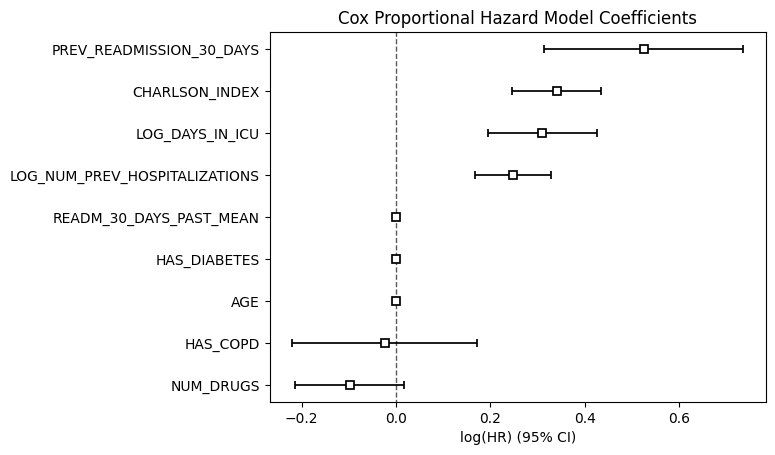

In [23]:
next_event_model_cph: NextEventPredictionModel = cph_model.model
next_event_model_cph.random_search_cv_results = search_results_cph
next_event_model_cph.model.print_summary()
ax = next_event_model_cph.model.plot()
save_coef_lifelines_plot(ax, next_event_model_cph)

In [ ]:
import io
import contextlib

# 2. Capture stdout of check_assumptions
buffer = io.StringIO()
with contextlib.redirect_stdout(buffer):
    next_event_model_cph.model.check_assumptions(X_train_scaled[features + ['EVENT_DURATION', 'READMISSION_EVENT']], p_value_threshold=0.05)

# 3. Get the full text output
check_assumptions_output = buffer.getvalue()



In [41]:
next_event_model_cph.plot_survival_function(X_train_scaled.iloc[:5], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

In [42]:
next_event_model_cph.plot_survival_function(X_test_scaled.iloc[:-4], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

##### Evaluation Train Dataset

In [43]:
c_index_cox_ph = next_event_model_cph.evaluate_c_index(X_train_scaled, save_metric=True, evaluation_set="train")
print(f"Train C-index for Cox Proportional Hazards Model: {c_index_cox_ph:.4f}")

Train C-index for Cox Proportional Hazards Model: 0.6377


In [ ]:
import matplotlib.pyplot as plt

from recurrent_health_events_prediction.training.utils_survival import evaluate_model_around_specific_time

# Predict survival probabilities for a specific time point
time_point = 30  # Example time point
predicted_probs_df, auc = evaluate_model_around_specific_time(next_event_model_cph, X_train_scaled, time_point, evaluation_set='train')


##### Evaluation Test Dataset

In [45]:
next_event_model_cph.evaluate_c_index(X_test_scaled, save_metric=True, evaluation_set='test')

0.5828965651739353

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_cph,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
    evaluation_set='test',
)

Test C-index for Cox Proportional Hazard Model: 0.5829


Mean AUC-ROC for Cox Proportional Hazard Model: 0.6167


In [24]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model_around_specific_time

prob_df, auc_roc = evaluate_model_around_specific_time(
    next_event_model_cph,
    X_test_scaled,
    evaluation_time=30,
    save_plots=True,
    evaluation_set='test'
)

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import plot_bad_good_predictions_event_ocurring

plot_bad_good_predictions_event_ocurring(
    events_df=last_events_df,
    prob_df=prob_df,
    prob_col='survival_prob_at_t',
    features=features,
    true_event_col='true_event',
    event_id_col='HADM_ID',
    good_survival_threshold=0.5,
    bad_survival_threshold=0.6
)

In [31]:
from recurrent_health_events_prediction.model.explainers import explain_survival_model_prob
from recurrent_health_events_prediction.training.train_traditional_survival_model import plot_feature_importance_survival_model
import shap
import matplotlib.pyplot as plt

def plot_survival_shap_summary(model: NextEventPredictionModel, X_train, X_explain, t=30, title=None):
    """
    Generate and return a SHAP summary plot figure for survival probability at time `t`.
    
    Parameters:
    - model: trained NextEventPredictionModel
    - X_train: background data (usually training data)
    - X_explain: data to explain (e.g., test data or subset of training)
    - t: float, time at which to compute survival probabilities
    - title: optional plot title
    
    Returns:
    - fig: matplotlib.figure.Figure
    """
    feature_names = model.feature_names_in_
    # Ensure only selected features are used
    X_train_subset = X_train[feature_names].copy()
    X_explain_subset = X_explain[feature_names].copy()
    
    # Get SHAP values
    shap_values, _ = explain_survival_model_prob(
        model, X_train_subset, X_explain_subset, t=t
    )
    
    # Handle binary/multiclass shape
    if shap_values.ndim == 3:
        shap_values_to_plot = shap_values[:, :, 1]  # Class 1 survival
    else:
        shap_values_to_plot = shap_values

    # Create figure for SHAP plot
    fig = plt.figure()
    plt.title(title or f"SHAP Summary Plot (t={t})", pad=20)
    shap.summary_plot(shap_values_to_plot, 
                      X_explain_subset.astype(float),
                      feature_names=feature_names,
                      show=False)  # Don't auto-show so we can return fig
    return fig

  0%|          | 0/100 [00:00<?, ?it/s]

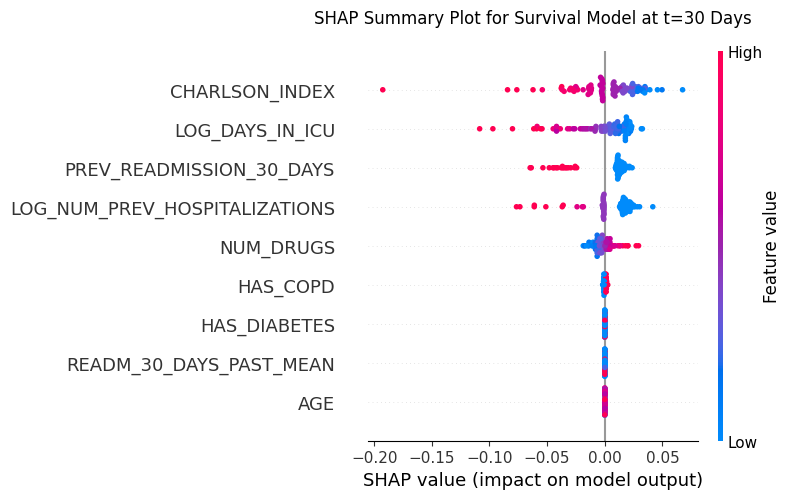

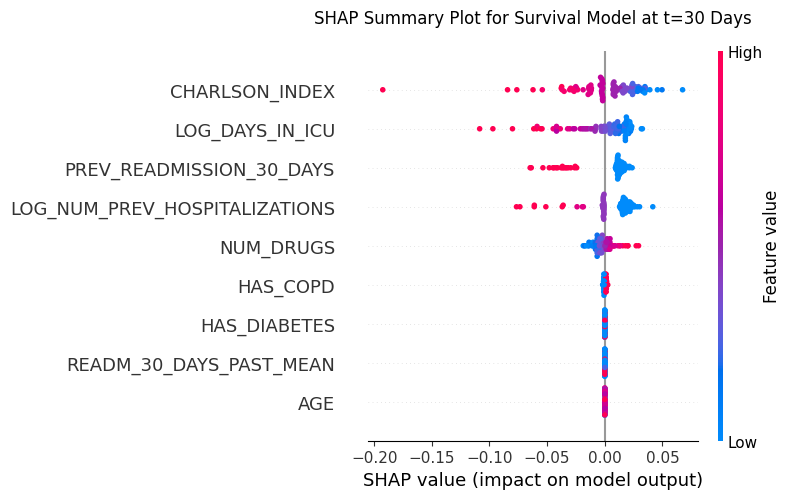

In [32]:
plot_survival_shap_summary(next_event_model_cph, X_train_scaled.iloc[:100], X_test_scaled.iloc[:100], t=30, title="SHAP Summary Plot for Survival Model at t=30 Days")

#### Cox PH - All Events

In [49]:
cph_se_model_config = next_event_model_config['last_event_based'].copy()
cph_se_model_config["model_name"] = "Cox Proportional Hazard Model with SE"
cph_se_model_config["model_type"] = SurvivalModelType.COX_PH
cph_se_model_config["cluster_col"] = "SUBJECT_ID"
cph_se_model_config["strata_col"] = None
cph_se_model_config

{'model_name': 'Cox Proportional Hazard Model with SE',
 'model_type': <SurvivalModelType.COX_PH: 'cox_ph'>,
 'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based',
 'strata_col': None,
 'event_col': 'READMISSION_EVENT',
 'event_id_col': 'HADM_ID',
 'duration_col': 'EVENT_DURATION',
 'cluster_col': 'SUBJECT_ID',
 'features': ['AGE',
  'READM_30_DAYS_PAST_MEAN',
  'PREV_READMISSION_30_DAYS',
  'CHARLSON_INDEX',
  'LOG_NUM_PREV_HOSPITALIZATIONS',
  'LOG_DAYS_IN_ICU',
  'NUM_DRUGS',
  'HAS_DIABETES',
  'HAS_COPD']}

In [50]:
X_train_scaled['READM_30_DAYS_PAST_MEAN'].describe()

count    1.352000e+03
mean     2.233585e-17
std      1.000370e+00
min     -6.628576e-01
25%     -6.628576e-01
50%     -6.628576e-01
75%      6.939741e-01
max      2.050806e+00
Name: READM_30_DAYS_PAST_MEAN, dtype: float64

In [51]:
X_train_scaled_all_events['READM_30_DAYS_PAST_MEAN'].fillna(0, inplace=True)

/tmp/ipykernel_6237/3890240315.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
from recurrent_health_events_prediction.training.utils_survival import train_next_event_survival_model_rand_search_cv

random_search_cph_se = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled_all_events,
    model_config=cph_se_model_config,
    strata_col_s=strata_col_all_events,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv
)

cph_se_model = random_search_cph_se.best_estimator_
cph_se_model

NextEventSurvivalWrapper(columns_order=['AGE', 'READM_30_DAYS_PAST_MEAN',
                                        'PREV_READMISSION_30_DAYS',
                                        'CHARLSON_INDEX',
                                        'LOG_NUM_PREV_HOSPITALIZATIONS',
                                        'LOG_DAYS_IN_ICU', 'NUM_DRUGS',
                                        'HAS_DIABETES', 'HAS_COPD',
                                        'EVENT_DURATION', 'READMISSION_EVENT',
                                        'SUBJECT_ID'],
                         model_config={'cluster_col': 'SUBJECT_ID',
                                       'duration_col': 'EVENT_DURATION',
                                       'event_col': 'READMISSI...
                                       'model_params': {'l1_ratio': np.float64(0.7394736842105263),
                                                        'penalizer': np.float64(0.01)},
                                       'model_type': <SurvivalModelType.COX_PH: 'cox_ph'>,
                                       'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based',
                                       'strata_col': None},
                         model_params={'l1_ratio': np.float64(0.7394736842105263),
                                       'penalizer': np.float64(0.01)})

In [53]:
search_results_cph_se = summarize_search_results(random_search_cph_se, model_name=cph_se_model_config["model_name"])

10 candidates of Cox proportional hazard model with se trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.01), 'l1_ratio': np.float64(0.7394736842105263)}}
Validation Score - Cox proportional hazard model with se: 0.614 ± 0.010


model,lifelines.CoxPHFitter
duration col,'EVENT_DURATION'
event col,'READMISSION_EVENT'
cluster col,'SUBJECT_ID'
penalizer,0.01
l1 ratio,0.739474
robust variance,True
baseline estimation,breslow
number of observations,4190
number of events observed,2101
partial log-likelihood,-16722.85


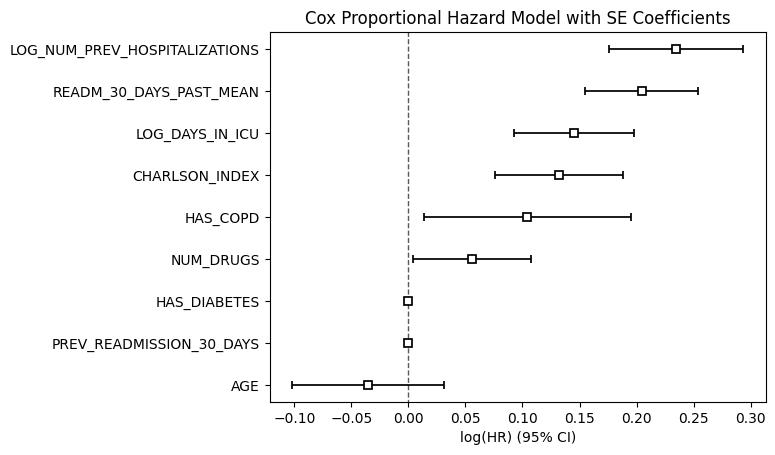

In [54]:
next_event_model_cph_se: NextEventPredictionModel = cph_se_model.model
next_event_model_cph_se.random_search_cv_results = search_results_cph_se
next_event_model_cph_se.model.print_summary()
ax = next_event_model_cph_se.model.plot()
save_coef_lifelines_plot(ax, next_event_model_cph_se)

In [55]:
_ = next_event_model_cph_se.model.check_assumptions(X_train_scaled_all_events[features + ['EVENT_DURATION', 'READMISSION_EVENT', 'SUBJECT_ID']], p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4190 total observations, 2089 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic      p  -log2(p)
AGE                           km              1.67   0.20      2.35
                              rank            1.67   0.20      2.35
CHARLSON_INDEX                km              0.54   0.46      1.11
                              rank            0.54   0.46      1.11
HAS_COPD                      km              1.39   0.24      2.07
                              rank            1.39   0.24      2.07
HAS_DIABETES                  km              0.08   0.77      0.37
                              rank            0.08   0.77      0.37
LOG_DAYS_IN_ICU               km              8.79 <0.005      8.37
                              rank            8.79 <0.005      8.37
LOG_NUM_PREV_HOSPITALIZATIONS km              5.39   0.02      5.62
                              rank            5.39   0.02      5.62
NUM_DRUGS                     km              0.13   0.72      0.48
                              rank            0.13   0.72      0.48
PREV_READMISSION_30_DAYS      km              0.10   0.75      0.41
                              rank            0.10   0.75      0.41
READM_30_DAYS_PAST_MEAN       km              1.17   0.28      1.84
                              rank            1.17   0.28      1.84



1. Variable 'LOG_NUM_PREV_HOSPITALIZATIONS' failed the non-proportional test: p-value is 0.0203.

   Advice 1: the functional form of the variable 'LOG_NUM_PREV_HOSPITALIZATIONS' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'LOG_NUM_PREV_HOSPITALIZATIONS' using pd.cut, and then specify
it in `strata=['LOG_NUM_PREV_HOSPITALIZATIONS', ...]` in the call in `.fit`. See documentation in
link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'LOG_DAYS_IN_ICU' failed the non-proportional test: p-value is 0.0030.

   Advice 1: the functional form of the variable 'LOG_DAYS_IN_ICU' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive

In [56]:
next_event_model_cph_se.plot_survival_function(X_train_scaled_all_events.iloc[:5], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

In [57]:
next_event_model_cph_se.plot_survival_function(X_test_scaled_all_events.iloc[:6], duration_col='EVENT_DURATION', n=6, event_col='READMISSION_EVENT')

##### Evaluation Train Dataset

In [58]:
c_index_cox_ph_all_events = next_event_model_cph_se.evaluate_c_index(X_train_scaled_all_events, save_metric=True, evaluation_set='train')
print(f"Train C-index for Cox Proportional Hazards Model with all events: {c_index_cox_ph_all_events:.4f}")

Train C-index for Cox Proportional Hazards Model with all events: 0.6151


##### Evaluation Test Dataset

In [59]:
X_test_scaled_all_events["READM_30_DAYS_PAST_MEAN"].fillna(0, inplace=True)
next_event_model_cph_se.evaluate_c_index(X_test_scaled_all_events, save_metric=True, evaluation_set='test')

/tmp/ipykernel_6237/693151246.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





0.6166567286780661

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_cph_se,
    X_train_scaled_all_events,
    X_test_scaled_all_events,
    evaluation_times=evaluation_times,
    save_plots=True,
    evaluation_set='test',
)

Test C-index for Cox Proportional Hazard Model with SE: 0.6167


Mean AUC-ROC for Cox Proportional Hazard Model with SE: 0.6395


In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model_around_specific_time

prob_df_all_events, auc_roc_all_events = evaluate_model_around_specific_time(
    next_event_model_cph_se,
    X_test_scaled_all_events,
    evaluation_time=30,
    save_plots=True,
    evaluation_set='test'
)

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import plot_bad_good_predictions_event_ocurring

plot_bad_good_predictions_event_ocurring(
    events_df=all_events_df,
    prob_df=prob_df_all_events,
    prob_col='survival_prob_at_t',
    features=features,
    true_event_col='true_event',
    event_id_col='HADM_ID',
    good_survival_threshold=0.5,
    bad_survival_threshold=0.6
)

#### AFT Weibull - Last Event Features 

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import train_next_event_survival_model_rand_search_cv

aft_weibull_model_config = next_event_model_config['last_event_based'].copy()
aft_weibull_model_config["model_type"] = SurvivalModelType.WEIBULL_AFT
aft_weibull_model_config["cluster_col"] = None
aft_weibull_model_config["strata_col"] = None
aft_weibull_model_config["model_name"] = "AFT Weibull Model"

random_search_aft_weibull = train_next_event_survival_model_rand_search_cv(
        training_df=X_train_scaled,
        model_config=aft_weibull_model_config,
        strata_col_s=strata_col,
        param_grid=param_lifelines_grid,
        n_iter=n_iter,
        random_state=random_state,
        cv=cv
)

aft_weibull_model = random_search_aft_weibull.best_estimator_

In [96]:
search_results_aft_weibull = summarize_search_results(random_search_aft_weibull, model_name="AFT Weibull Model")

10 candidates of Aft weibull model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.14), 'l1_ratio': np.float64(0.06210526315789474)}}
Validation Score - Aft weibull model: 0.630 ± 0.009


<lifelines.WeibullAFTFitter: fitted with 1352 total observations, 710 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.14
   number of observations = 1352
number of events observed = 642
           log-likelihood = -3839.06
         time fit was run = 2025-07-15 19:27:23 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                      
lambda_ AGE                           -0.00      1.00      0.05           -0.09            0.09                0.91                1.10
        CHARLSON_INDEX                -0.24      0.79      0.05           -0.33           -0.15                0.72                0.86
        HAS_COPD                      -0.09      0.91      0.08           -0.26            0.07                0.77                1.07
        HAS_DIABETES                  -0.08      0.93      0.09           -0.25            0.09                0.78                1.10
        LOG_DAYS_IN_ICU               -0.15      0.86      0.05           -0.24           -0.06                0.79                0.94
        LOG_NUM_PREV_HOSPITALIZATIONS -0.16      0.86      0.04           -0.23           -0.08                0.79                0.93
        NUM_DRUGS                      0.00      1.00      0.05           -0.09            0.09                0.92                1.09
        PREV_READMISSION_30_DAYS      -0.28      0.76      0.12           -0.51           -0.05                0.60                0.95
        READM_30_DAYS_PAST_MEAN       -0.17      0.85      0.05           -0.27           -0.07                0.77                0.94
        Intercept                      5.43    229.12      0.09            5.27            5.60              193.65              271.08
rho_    Intercept                     -0.25      0.78      0.03           -0.31           -0.18                0.74                0.83

                                       cmp to     z      p  -log2(p)
param   covariate                                                   
lambda_ AGE                              0.00 -0.00   1.00      0.00
        CHARLSON_INDEX                   0.00 -5.10 <0.005     21.49
        HAS_COPD                         0.00 -1.11   0.27      1.91
        HAS_DIABETES                     0.00 -0.87   0.38      1.39
        LOG_DAYS_IN_ICU                  0.00 -3.32 <0.005     10.09
        LOG_NUM_PREV_HOSPITALIZATIONS    0.00 -3.84 <0.005     13.00
        NUM_DRUGS                        0.00  0.02   0.98      0.03
        PREV_READMISSION_30_DAYS         0.00 -2.39   0.02      5.88
        READM_30_DAYS_PAST_MEAN          0.00 -3.24 <0.005      9.70
        Intercept                        0.00 63.33 <0.005       inf
rho_    Intercept                        0.00 -7.92 <0.005     48.58
---
Concordance = 0.64
AIC = 7700.11
log-likelihood ratio test = 70.34 on 9 df
-log2(p) of ll-ratio test = 36.16

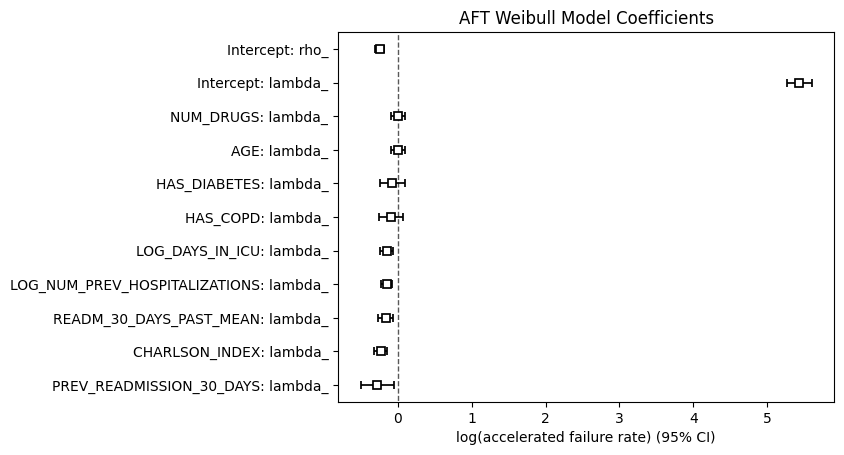

In [65]:
next_event_model_aft_weibull: NextEventPredictionModel = aft_weibull_model.model
next_event_model_aft_weibull.model.print_summary()
ax = next_event_model_aft_weibull.model.plot()
save_coef_lifelines_plot(ax, next_event_model_aft_weibull)

In [41]:
next_event_model_aft_weibull.plot_survival_function(X_test_scaled, duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

NameError: name 'next_event_model_aft_weibull' is not defined

##### Evaluation Train Dataset

In [67]:
c_index_aft_weibull = next_event_model_aft_weibull.evaluate_c_index(X_train_scaled, save_metric=True, evaluation_set='train')
print(f"Train C-index for AFT Weibull Model: {c_index_aft_weibull:.4f}")

Train C-index for AFT Weibull Model: 0.6370


##### Evaluation Test Dataset

In [68]:
next_event_model_aft_weibull.evaluate_c_index(X_test_scaled, save_metric=True, evaluation_set='test')

0.5843348528802321

In [69]:
evaluate_model(
    next_event_model_aft_weibull,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
)

Test C-index for AFT Weibull Model: 0.5843


Mean AUC-ROC for AFT Weibull Model: 0.6182


In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model_around_specific_time
prob_df = evaluate_model_around_specific_time(
    next_event_model_aft_weibull,
    X_test_scaled,
    save_plots=True,
    evaluation_time=30,
)

#### Survival GBM - Last Events

In [102]:
survival_gbm_model_config = next_event_model_config['last_event_based'].copy()
survival_gbm_model_config["model_type"] = SurvivalModelType.GBM.value
survival_gbm_model_config["cluster_col"] = None
survival_gbm_model_config["strata_col"] = None
survival_gbm_model_config["model_name"] = "Survival GBM Model"

gbm_features = ['AGE',
   'READM_30_DAYS_PAST_MEAN',
   'PREV_READMISSION_30_DAYS',
   'CHARLSON_INDEX',
   'LOG_NUM_PREV_HOSPITALIZATIONS',
   'LOG_DAYS_IN_ICU',
   'NUM_DRUGS',
   'HAS_DIABETES',
   'HAS_COPD',
   'RANDOM_FEATURE']

survival_gbm_model_config["features"] = gbm_features


random_search_survival_gbm = train_next_event_survival_model_rand_search_cv(
    training_df=X_train,
    model_config=survival_gbm_model_config,
    strata_col_s=strata_col,
    param_grid=param_grid_gbm_survival,
    n_iter=10,
    random_state=random_state,
    cv=5
)

survival_gbm_model = random_search_survival_gbm.best_estimator_
random_search_survival_gbm

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0xfffef84a86d0>,
                   estimator=NextEventSurvivalWrapper(columns_order=['AGE',
                                                                     'READM_30_DAYS_PAST_MEAN',
                                                                     'PREV_READMISSION_30_DAYS',
                                                                     'CHARLSON_INDEX',
                                                                     'LOG_NUM_PREV_HOSPITALIZATIONS',
                                                                     'LOG_DAYS_IN_ICU',
                                                                     'NUM_DRUGS',
                                                                     'HAS_DIABETES',
                                                                     'HAS_COPD',
                                                                     'RANDOM_FEATURE',
                                                                     'EVENT_DURATION',
                                                                     'READMISSION_EVENT'],
                                                      model_con...
                                                          'n_estimators': 100},
                                                         {'learning_rate': np.float64(0.03111111111111111),
                                                          'max_depth': 5,
                                                          'n_estimators': 100},
                                                         {'learning_rate': np.float64(0.07333333333333333),
                                                          'max_depth': 7,
                                                          'n_estimators': 300},
                                                         {'learning_rate': np.float64(0.1366666666666667),
                                                          'max_depth': 4,
                                                          'n_estimators': 300},
                                                         {'learning_rate': np.float64(0.1366666666666667),
                                                          'max_depth': 6,
                                                          'n_estimators': 200}]},
                   random_state=42)

In [104]:
search_results_survival_gbm = summarize_search_results(random_search_survival_gbm, model_name="Survival GBM Model")

10 candidates of Survival gbm model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'n_estimators': 200, 'max_depth': 3, 'learning_rate': np.float64(0.03111111111111111)}}
Validation Score - Survival gbm model: 0.627 ± 0.019


In [105]:
next_event_model_gbm: NextEventPredictionModel = survival_gbm_model.model
next_event_model_gbm.random_search_cv_results = search_results_survival_gbm

In [106]:
next_event_model_gbm.plot_survival_function(X_test, n=5, event_col='READMISSION_EVENT', duration_col='EVENT_DURATION')

In [107]:
from recurrent_health_events_prediction.model.utils import plot_feature_importance

filepath = next_event_model_gbm.get_model_dir() + "/feature_importance.html"
title=f"Feature Importance {next_event_model_gbm.model_name}"
plot_feature_importance(next_event_model_gbm.model, title=title, n=10, save_path=filepath)

##### Evaluation Train Set

In [108]:
c_index_gbm = next_event_model_gbm.evaluate_c_index(X_train, save_metric=True, evaluation_set='train')
print(f"Train C-index for Survival Gradient Boosting Machine Model: {c_index_gbm:.4f}")

Train C-index for Survival Gradient Boosting Machine Model: 0.6993


##### Evaluation Test Set

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

evaluate_model(next_event_model_gbm, X_train, X_test, evaluation_times=evaluation_times, evaluation_set='test', save_plots=True)

Test C-index for Survival GBM Model: 0.5643


Mean AUC-ROC for Survival GBM Model: 0.5790


In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model_around_specific_time

prob_df, auc_roc = evaluate_model_around_specific_time(
    next_event_model_gbm,
    X_test,
    evaluation_time=30,
    save_plots=True,
)

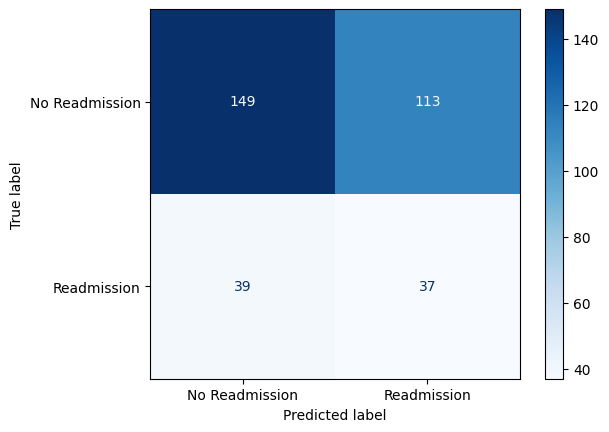

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import plot_confusion_matrix

labels = prob_df['event_at_t'].values
scores = prob_df['prob_event_happened_before_t'].values

plot_confusion_matrix(
    labels=labels,
    scores=scores,
    threshold=0.25,
)

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import plot_bad_good_predictions_event_ocurring

plot_bad_good_predictions_event_ocurring(
    events_df=last_events_df,
    prob_df=prob_df,
    prob_col='survival_prob_at_t',
    features=features,
    true_event_col='true_event',
    event_id_col='HADM_ID',
    good_survival_threshold=0.6,
    bad_survival_threshold=0.8
)

#### AFT Log Normal - Last Events 

In [82]:
aft_lognormal_model_config = next_event_model_config['last_event_based'].copy()
aft_lognormal_model_config["model_type"] = SurvivalModelType.LOGNORMAL_AFT.value
aft_lognormal_model_config["cluster_col"] = None
aft_lognormal_model_config["strata_col"] = None
aft_lognormal_model_config["model_name"] = "AFT Lognormal Model"
aft_lognormal_model_config["features"] = ["LOG_NUM_PREV_HOSPITALIZATIONS", "LOG_DAYS_IN_ICU", "CHARLSON_INDEX", "READM_30_DAYS_PAST_MEAN"]

random_search_aft_lognormal = train_next_event_survival_model_rand_search_cv(
        training_df=X_train_scaled,
        model_config=aft_lognormal_model_config,
        strata_col_s=strata_col,
        param_grid=param_lifelines_grid,
        n_iter=n_iter,
        random_state=random_state,
        cv=cv
)

aft_lognormal_model = random_search_aft_lognormal.best_estimator_

/workspaces/master-thesis-recurrent-health-events-prediction/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


8 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/workspaces/master-thesis-recurrent-health-events-prediction/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/workspaces/master-thesis-recurrent-health-events-prediction/recurrent_health_events_prediction/model/NextEventPredictionModel.py", line 755, in fit
    self.model.fit(X)
  File "/workspaces/master-thesis-r

In [83]:
search_results_aft_log_normal = summarize_search_results(random_search_aft_lognormal, model_name="AFT Lognormal Model")

7 candidates of Aft lognormal model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.01), 'l1_ratio': np.float64(0.7394736842105263)}}
Validation Score - Aft lognormal model: 0.634 ± 0.010


<lifelines.LogNormalAFTFitter: fitted with 1352 total observations, 710 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.01
   number of observations = 1352
number of events observed = 642
           log-likelihood = -3803.16
         time fit was run = 2025-07-15 19:27:40 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                      
mu_    CHARLSON_INDEX                -0.40      0.67      0.06           -0.53           -0.28                0.59                0.75
       LOG_DAYS_IN_ICU               -0.24      0.79      0.06           -0.36           -0.12                0.70                0.89
       LOG_NUM_PREV_HOSPITALIZATIONS -0.24      0.79      0.06           -0.35           -0.12                0.70                0.89
       READM_30_DAYS_PAST_MEAN       -0.38      0.69      0.06           -0.50           -0.26                0.61                0.77
       Intercept                      4.88    131.82      0.07            4.74            5.02              114.76              151.42
sigma_ Intercept                      0.71      2.03      0.03            0.65            0.77                1.91                2.15

                                      cmp to     z      p  -log2(p)
param  covariate                                                   
mu_    CHARLSON_INDEX                   0.00 -6.49 <0.005     33.46
       LOG_DAYS_IN_ICU                  0.00 -3.85 <0.005     13.07
       LOG_NUM_PREV_HOSPITALIZATIONS    0.00 -3.94 <0.005     13.61
       READM_30_DAYS_PAST_MEAN          0.00 -6.16 <0.005     30.33
       Intercept                        0.00 69.02 <0.005       inf
sigma_ Intercept                        0.00 23.20 <0.005    393.03
---
Concordance = 0.64
AIC = 7618.33
log-likelihood ratio test = 92.24 on 4 df
-log2(p) of ll-ratio test = 60.98

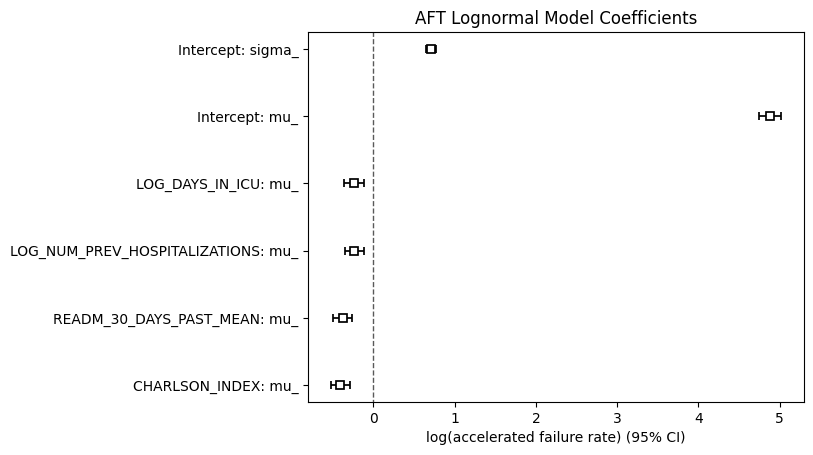

In [84]:
next_event_model_aft_log_normal: NextEventPredictionModel = aft_lognormal_model.model
next_event_model_aft_log_normal.random_search_cv_results = search_results_aft_log_normal
next_event_model_aft_log_normal.model.print_summary()
ax = next_event_model_aft_log_normal.model.plot()
save_coef_lifelines_plot(ax, next_event_model_aft_log_normal)

In [86]:
next_event_model_aft_log_normal.plot_survival_function(X_test_scaled, duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

##### Evaluation Train Set

In [87]:
c_index_log_normal_aft = next_event_model_aft_log_normal.evaluate_c_index(X_train_scaled, save_metric=True, evaluation_set='train')
print(f"Train C-index for AFT Lognormal Model: {c_index_log_normal_aft:.4f}")

Train C-index for AFT Lognormal Model: 0.6368


##### Evaluation Test Dataset

In [88]:
next_event_model_aft_log_normal.evaluate_c_index(X_test_scaled, save_metric=True, evaluation_set='test')

0.5844567416689013

In [89]:
evaluate_model(
    next_event_model_aft_log_normal,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
    evaluation_set='test',
)

Test C-index for AFT Lognormal Model: 0.5845


Mean AUC-ROC for AFT Lognormal Model: 0.6219


In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model_around_specific_time

prob_df = evaluate_model_around_specific_time(
    next_event_model_aft_log_normal,
    X_test_scaled,
    evaluation_time=30,
    evaluation_set='test',
    save_plots=True,
)

In [92]:
search_results_aft_log_normal

{'model_name': 'AFT Lognormal Model',
 'best_score_mean': 0.6337973505605335,
 'best_score_std': 0.010196690491368616,
 'n_fitted_candidates': np.int64(7),
 'num_folds': 5,
 'best_params': {'model_params': {'penalizer': np.float64(0.01),
   'l1_ratio': np.float64(0.7394736842105263)}}}

## Final Results

In [114]:
models = [next_event_model_km, next_event_model_cph, next_event_model_aft_log_normal, next_event_model_aft_weibull, next_event_model_gbm, next_event_model_cph_se]
random_search_results = [None, search_results_cph, search_results_aft_log_normal, search_results_aft_weibull, search_results_survival_gbm, search_results_cph_se]

for model in models:
    model.save_model()
    if model.random_search_cv_results is not None:
        model.save_random_search_cv_results()
    model.save_key_performance_metrics()
    model.save_model_params()

summary_results = {
    "Model": [],
    "Features": [],
    "C-Index": [],
    "Avg. Brier Score": [],
    "AUC 30 Days": [],
    "Avg. Time-Dependent AUC": []
}

cross_validation_results = {
    "Model": [],
    "Num Candidates": [],
    "Folds": [],
    "Mean C-Index": [],
    "Std C-Index": []

}

for model in models:
    summary_results["Model"].append(model.model_name)
    summary_results["Features"].append(", ".join(model.feature_names_in_))
    summary_results["C-Index"].append(model.key_test_performance_metrics['c_index'])
    summary_results["Avg. Brier Score"].append(model.key_test_performance_metrics['avg_brier_score'])
    summary_results["AUC 30 Days"].append(model.key_test_performance_metrics.get('auc_roc_at_t_30', 0.5))
    summary_results["Avg. Time-Dependent AUC"].append(model.key_test_performance_metrics['avg_cumulative_dynamic_auc'])

for rand_search_result in random_search_results:
    if rand_search_result is None:
        continue
    cross_validation_results["Model"].append(rand_search_result["model_name"])
    cross_validation_results["Num Candidates"].append(rand_search_result["n_fitted_candidates"])
    cross_validation_results["Folds"].append(rand_search_result["num_folds"])
    cross_validation_results["Mean C-Index"].append(rand_search_result["best_score_mean"])
    cross_validation_results["Std C-Index"].append(rand_search_result["best_score_std"])

Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/kaplan_meier_estimator/kaplan_meier_estimator.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/cox_proportional_hazard_model/cox_proportional_hazard_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/aft_lognormal_model/aft_lognormal_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/aft_weibull_model/aft_weibull_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/survival_gbm_model/survival_gbm_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/cox_proportional_hazard_model_with_se/cox_proportional_haz

In [115]:
summary_df = pd.DataFrame(summary_results)
summary_df = summary_df.sort_values(by="C-Index", ascending=False)
summary_df.reset_index(drop=True, inplace=True)
summary_df

,Model,Features,C-Index,Avg. Brier Score,AUC 30 Days,Avg. Time-Dependent AUC
0,Cox Proportional Hazard Model with SE,"AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...",0.616657,0.200168,0.645794,0.639507
1,AFT Lognormal Model,"LOG_NUM_PREV_HOSPITALIZATIONS, LOG_DAYS_IN_ICU...",0.584457,0.191556,0.608126,0.621886
2,AFT Weibull Model,"AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...",0.584335,0.191064,0.604259,0.618224
3,Cox Proportional Hazard Model,"AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...",0.582897,0.192230,0.604108,0.616685
4,Survival GBM Model,"AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...",0.564321,0.197555,0.565840,0.579000
5,Kaplan Meier Estimator,"AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...",0.500000,0.200058,0.500000,0.500000


In [116]:
cross_validation_results_df = pd.DataFrame(cross_validation_results)
cross_validation_results_df = cross_validation_results_df.sort_values(by="Mean C-Index", ascending=False)
cross_validation_results_df.reset_index(drop=True, inplace=True)
cross_validation_results_df

,Model,Num Candidates,Folds,Mean C-Index,Std C-Index
0,AFT Lognormal Model,7,5,0.633797,0.010197
1,Cox Proportional Hazard Model,10,5,0.630789,0.008323
2,AFT Weibull Model,10,5,0.630383,0.008564
3,Survival GBM Model,10,5,0.626890,0.018679
4,Cox Proportional Hazard Model with SE,10,5,0.613570,0.009968


In [ ]:
with open("search_results_cph.txt", "w") as f:
    f.write(str(random_search_cph.cv_results_))

with open("search_results_cph_se.txt", "w") as f:
    f.write(str(random_search_cph_se.cv_results_))

with open("aft_weibull_search_results.txt", "w") as f:
    f.write(str(random_search_aft_weibull.cv_results_))

with open("search_results_aft_log_normal.txt", "w") as f:
    f.write(str(random_search_aft_lognormal.cv_results_))

with open("search_results_survival_gbm.txt", "w") as f:
    f.write(str(random_search_survival_gbm.cv_results_))

summary_df.to_csv("model_summary_results.csv", index=False)
print("Model summary results saved to model_summary_results.csv")

Model summary results saved to model_summary_results.csv
